In [1]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import ARCH, GARCH, Naive
import yfinance as yf
from typing import List, Union, Callable
import random
from time import perf_counter

from lib.statsforecast import preprocess_yf
from lib.utils import log_returns, squared_returns

/Users/beneverman/Documents/Coding/bp-quant/forecasting-experiments-v1/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data

In [29]:
tickers = ["AAPL", "MSFT", "GOOG", "NFLX", "META"] # MAANG
start = "2018-01-01"
end = "2023-10-04" # 5 yrs
interval = "1d" # daily 

df = yf.download(tickers, start=start, end=end, interval=interval)

[*********************100%%**********************]  5 of 5 completed


## Preprocess

In [31]:
df = preprocess_yf(df, squared_returns)

## Model

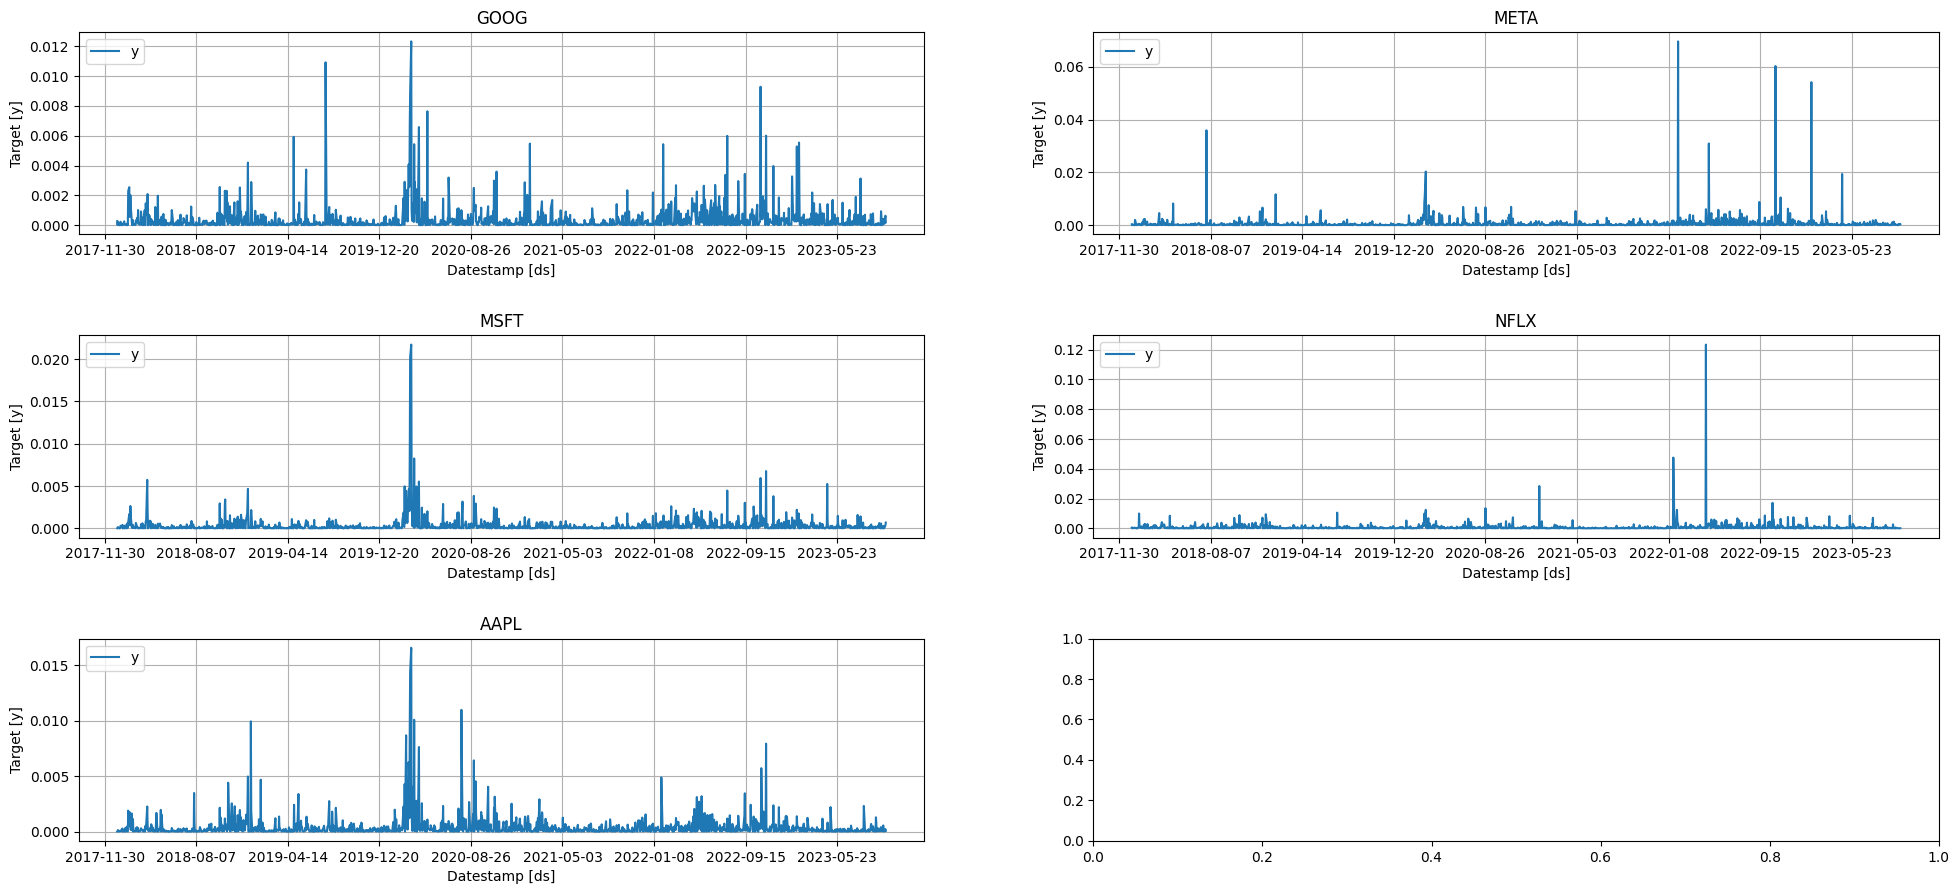

In [32]:
StatsForecast.plot(df)

In [33]:
models = [
    Naive(),
    ARCH(1),
    ARCH(2),
    GARCH(1, 1),
    GARCH(1, 2),
    GARCH(2, 1),
    GARCH(2, 2), # might overfit
    GARCH(3, 3), # might overfit
]

sf = StatsForecast(
    df = df, 
    models = models, 
    freq = "B", # business days
    n_jobs = -1
)

In [36]:
cvdf = sf.cross_validation(
    df = df,
    h = 1, # forecast horizon
    step_size = 1, # step size between forecasts 
    n_windows = 20 # number of windows to use (4 weeks)
)

In [37]:
cvdf.reset_index(inplace=True)

In [40]:
cvdf.to_csv("../data/arch_arch_h1_s1_n20.csv")

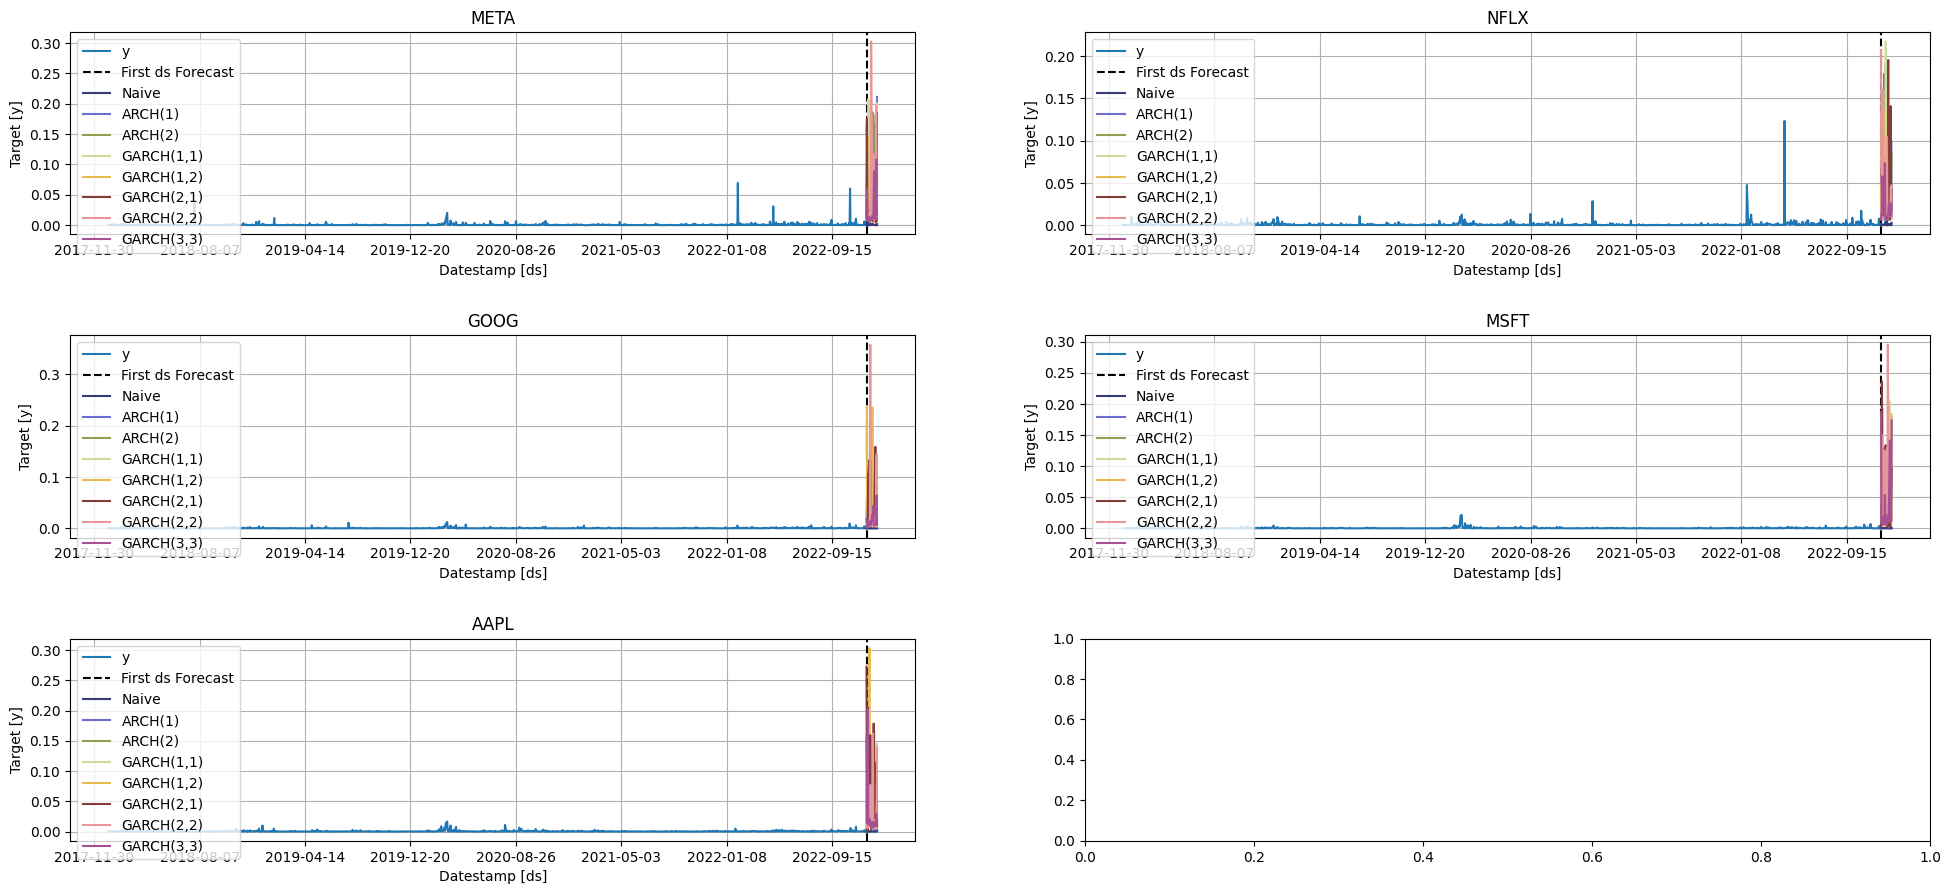

In [28]:
StatsForecast.plot(df, cvdf.drop(["cutoff", "y"], axis=1))

In [15]:
class ErrorFuncs:
    @staticmethod
    def mae(y_true: pd.Series, y_pred: pd.Series): return np.mean(np.abs(y_true - y_pred))
    @staticmethod
    def mse(y_true: pd.Series, y_pred: pd.Series): return np.mean((y_true - y_pred)**2)
    @staticmethod
    def rmse(y_true: pd.Series, y_pred: pd.Series):return np.sqrt(ErrorFuncs.mse(y_true, y_pred))
    @staticmethod
    def mape(y_true: pd.Series, y_pred: pd.Series): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
def compute_error(cvdf: pd.DataFrame, models: List, error_func: Callable):
    res = {}
    for mod in models:
        res[mod] = error_func(cvdf.loc[:, 'y'], cvdf.loc[:, str(mod)])
    return res

In [23]:
errors_df = cvdf.groupby(['unique_id', 'cutoff']).apply(
    lambda x: pd.Series(compute_error(x, models, ErrorFuncs.mse))
).reset_index()

In [24]:
mean_errors_df = errors_df.groupby('unique_id').mean() # mean errors
mean_errors_df.reset_index(inplace=True)
mean_errors_df.drop(['unique_id', 'cutoff'], axis=1).style.highlight_min(axis=1, color='red')

,Naive,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,1)","GARCH(2,2)","GARCH(3,3)"
0,0.000001,0.000527,0.000455,0.001958,0.003787,0.002406,0.001364,0.000206
1,0.000002,0.003124,0.000171,0.002428,0.001285,0.002311,0.004105,0.000324
2,0.000050,27770182646628352.000000,0.001879,0.001348,0.000877,0.003314,0.003172,0.000961
3,0.000001,0.001084,17976.410156,10.781400,0.000633,0.001067,0.000384,0.001434
4,0.000004,0.002188,0.001456,0.002647,0.001699,0.001119,0.002952,3853.271484
